# Meta Human

This project is part of the course "Musikinformatik" held in 2022 by Dennis Scheiba, Marcus Schmickler and Julian Rohrhuber at the Institute of music and media in Düsseldorf.

## Introduction
The goal of this project is to write an algorithm that is able to create meta-human music. If you are interested in what we mean by "meta-human music" please read the pdf "Konzept". For that we as human programmers want to make as little creative decisions as possible and leave as many as possible to machines. 

To achieve that, we want to create two independent neural networks (called "Valerio" and "Dennis"), that are able to produce sounds, listen to sounds and learn from heard sounds. 

Each of these two networks is constructed by two sub-networks (ML1 and ML2). 
ML1 can generate small junks of audio (1/4 - 4 seconds). ML2 can arrange these junks to form a song. ML2 therefore is responsible for the larger structure of the song, while ML1 should produce smaller sound-structures.

In this documentation we will describe the process of creating the two sub-networks (ML1 and ML2) of one supra-network (Valerio). The other supra-network (Dennis) can be built in the same style with it's own training data (e.g. a different instrument) and different hyper-parameters (e.g. a different length for the audio junks).

If you are only interested in the results, you can skip all notebooks and jump to notebook "6 Conversation". There the two supra-networks "talk" to each other. One produces a song and the other responds. You will need to download the trained models to run the code. You can find them here: https://drive.google.com/drive/folders/1IU1-62HpnQDz7yyQlBsNWtEvn7Ym5lgc?usp=sharing

## Technical Overview

Here is an overview of the steps we take to create one of the supra-networks with its two sub-networks:

1. Collect data for ML1: single-instrument stems of songs
2. Pre-Process data for ML1: Split data in small junks of a few seconds
3. Train ML1 with the junks
4. Collect data for ML2: store the order of the small junks in the song
5. Train ML2 with the orders
6. Combine ML1 and ML2: ML2 tells ML1 which junks to produce in which order

### ML1 - Audio Snippets

We want the first subnetwork (ML1) to produce small junks of audio with a duration of a few seconds or less. We call these junks snippets. We have trained an autoencoder to perform this task. An autoencoder is an architecture with an encoder-part and a decoder-part. 

The encoder takes complex data with many dimensions as input and reduces its complexity to less dimensions. In our case the complex input data are mel-spectrograms of audio snippets. They have a dimensionality of n x m, where n is the number of frequency bins (in our case 128) and m is the number of time frames (16-256). The encoder can reduce this data to a lower dimension, e.g. to 2D, and arrange it in the so-called latent space. Two dimensions are nice for humans, as they can be represented in an scatter plot, like this one:

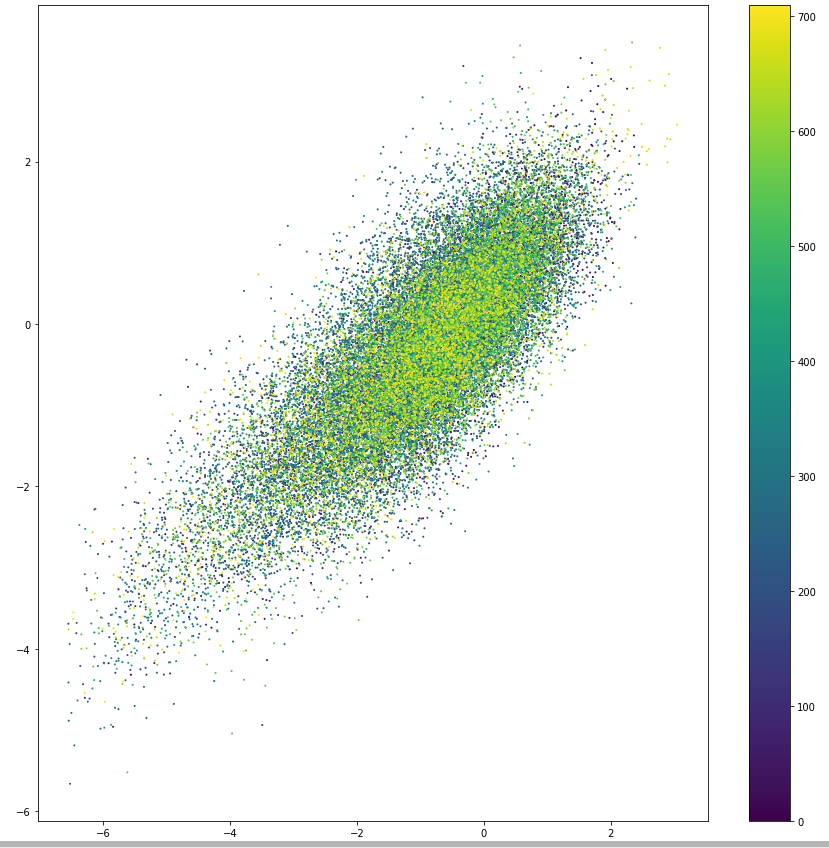

Here each single dot in the plot corresponds to one short snippet of audio. The task of the encoder is, to analyze the audio data and decide where to place each dot in this two-dimensional space. It tries to do it in a way that allows the decoder to reconstruct the audio signal only from the position of the dot in the latent space. 

The decoder gets the coordinates of one dot as input and reconstructs the complex data from it - in our case a mel-spectogram. We could now just give the decoder a random point in the latent space and would get back a new mel-spectrogram, from which we could reconstruct a new sound. 

Of course some information is lost during this process. In fact an autoencoder can be described as an compression-decompression algorithm. 

To make things clearer, we can look at a single song with a duration of 80 seconds. First we split that song into 40 2-second-snippets of audio. If we feed the encoder these snippets, we get 40 dots in the latent space: 

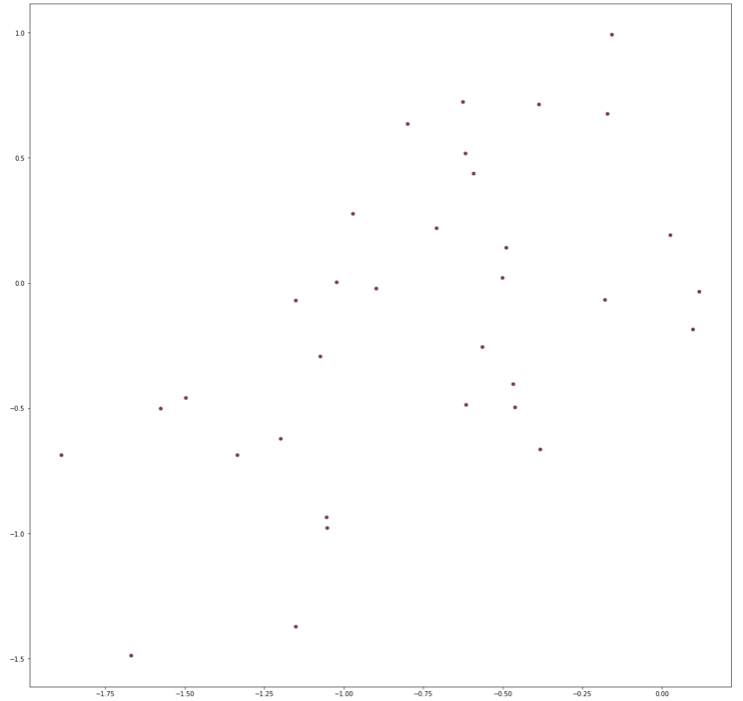

As the song is a sequence of its snippets, it can be represented as a series of jumps from one dot to the next. Here the first snippet is connected to the second, which is connected to the third and so on:

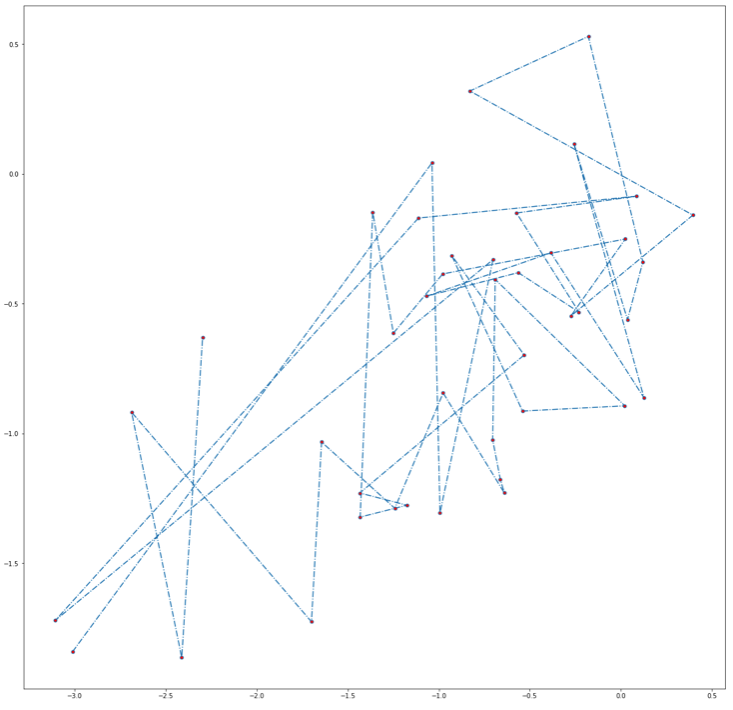

We can see, that each song corresponds to a "movement" through the latent space. This movement can be described by a sequence of the coordinates of each dot. Thus, our song can be described as a sequence of 40 2-dimensional coordinates. 

As stated above the two-dimensional latent space is very nice for us humans, as we can look at it on a screen. Three dimensions would be ok too, as we at least can imagine a movement through a 3D space. But as soon as we create a higher dimensional latent space, we have problems imagining this space and a "movement" of one song through this space. But that is a human restriction. Machines can easily work with much higher dimensions. 

In fact the higher the latent space dimension, the less information gets lost during the process of encoding and decoding. That's why we've used a 128D latent space. That means that each dot now is described by a 128D coordinate instead of just 2D. A song is then a sequence of 128D coordinates.


### ML2 - Song Orders

We've seen that every song corresponds to a movement through the latent space, i.e. a sequence of coordinates. Now if we want to create a machine learning model, that is able to compose such sequences, we need training data for it. Since we know at which position each snippet occured in a song, we can easily create the data ourselfs. We just store the movements as showed above for each song. 

With this data we can train another autoencoder. This one takes the sequence of coordinates as input and reduces it to its own latent space. We can then sample random points in that latent space to produce a new sequence of song ordes.

### Combing ML1 and ML2

As described in the previous section we can use ML2 to produce new song orders. For that we just point to a random dot in the latent space and let the decoder compose the corresponding sequence of coordinates. Now we have a representation of a song in the 128D latent space of ML1. It has the information which snippets of audio should be played in which order. 

We can give that sequence of coordinates to the decoder of ML1. It will produce an audio snippet (in form of a mel-spectrogram) for each 128D coordinate of the sequence ML2 produced.

In the last step we can just glue the snippets produced by ML1 together, in the order that ML2 produced, and get a song.

We now have one network (Valerio) based on two subnetworks (ML1 and ML2), that is able to compose a song order and fill it with audio snippets. 

### Conversation between Valerio and Dennis

As you can see, we've tried to create a program that relies as little as possible on human input to produce sounds. In fact the only human input that is needed, is a starting point in form of a random dot in the latent space of ML2. 

But remember that ML1 was trained on snippets of songs. Of course these songs were human songs. ML1 still tries to come as close as possible to its training data, i.e. to human music. Since our goal is to create "meta-human" music we train yet another network (Dennis) in the same style as the first one (Valerio), but with an independent set of songs. We can then create a closed loop between the two. 

First one of the two - let's say Valerio - starts by producing a song. Two starting points are possible:

1. Imitation of a human song: Valerio is given one of the song orders, that he was trained with. He can then use ML1 to reproduce that song.

2. Composing a machine song: As described above, Valerio is given a random dot in the latent space of ML2, and produces a song based on that. 

The other network - Dennis - is listening to the song and cuts it into snippets. Dennis takes these snippets as inputs for his encoder of ML1. He will try to find a latent representation of the snippets. Here again two routes are possible:

1. Imitation: Dennis tries to reproduce the song he just heard. In that case he just directly decodes the latent representation of the song he just heard. Note, that this will not produce an output that is identical to the input. Dennis was trained on different data then Valerio and hence has a different latent space as well as a different decoder and encoder. 

2. Variation: Dennis tries to come up with a slight variation of the song he just heard. In that case he slightly moves every coordinate of the song, producing a slight distortion of the movement in the latent space. He then decodes that new distorted coordinates and outputs the corresponding song.

Now Valerio can take the audio Dennis just produced and continue with one of the steps on his side (imitation or variation). We now have a closed loop. The two networks have a conversation about one song.

Additionally we add each song that is produced by one network to the training data of the other network. For example every song Dennis produces during that conversation is added to the training data of Valerio and vice versa. Like this Valerio can remember the songs Dennis produced. After a few iterations the two networks stop "singing" and "dream" instead, i.e. they retrain on their new dataset. 

The longer this process continues, the more machine-songs are in the dataset of the two models. At some point there will be more machine-songs in the dataset then human-songs. That means that more and more the two emancipate from their human idols. Like in Alvin Luciers sound art piece "I Am Sitting in a Room", we try to distill the machine part of the produced sounds, by forming the described closed loop. 

# Code

In the following notebooks we present the code that was used to implement ML1 and ML2 of Valerio and Dennis. We relied heavily on the code and tutorials of Dennis Scheiba and Valerio Velardo. They can be found here:

https://capital-g.github.io/musikinformatik-sose2021/

https://github.com/capital-G/musikinformatik-sose2021

https://www.youtube.com/c/ValerioVelardoTheSoundofAI


A note on the code:
We've worked in different Jupyter Notebooks to make things more clearly structured. This has the downside that code from one notebook can't be reached in another notebook. All important classes are duplicated in Python files (.py), since it is easy to import classes from python files into Notebooks. If you're following this documentation, you can just follow the notebooks from 0 to 6. There's no need to open the python files, since all classes defined there are also in a notebook.

Not all code will work on your machine. The training of the models needs training data. Our data is not included in the repository since it has several GB. Our trained models can be downloaded here: https://drive.google.com/drive/folders/1IU1-62HpnQDz7yyQlBsNWtEvn7Ym5lgc?usp=sharing. You can train your own model by changing the necessary paths to your own training data. In our experience relatively little data is necessary to train ML1 (a single album can be enough to at least get an impression). ML2 needs a lot more data. Note that the process works much better for single instrument songs. You can load your data to the folder "demo_data/stems" Be careful not to overwrite our trained models.